In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd
import pandas

import copy
import os

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


### Import plotting utilities and planar drone locally or from github

In [5]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

### Helper function to simulate a trajectory snippet with random properties

In [16]:
def simulate_snippet(dt, tsim_length, trim_indices, 
                     smoothness_x=0.15, smoothness_z=0.15, smoothness_theta=0.15,
                     amplitude_x=3., amplitude_z=3., amplitude_theta=3.,
                     nominal_z=5,
                     seed_x=42, seed_z=24, seed_theta=24,
                     trajectory_shape_x='spline', trajectory_shape_z='spline', trajectory_shape_theta='spline',
                     rterm=1e-1,
                     directory='.',
                     number=1):

    # establish the dynamics and measurement functions
    f = planar_drone.F(k=1).f
    h = planar_drone.H('h_camera_imu', k=1).h

    # set the sim time
    tsim = np.arange(0, tsim_length, step=dt)

    # generate smooth random setpoint trajectories for the three base states
    theta_curve = planar_drone.generate_smooth_curve(tsim, method=trajectory_shape_theta, 
                                                 smoothness=smoothness_theta, amplitude=amplitude_theta, seed=seed_theta)
    x_curve = planar_drone.generate_smooth_curve(tsim, method=trajectory_shape_x, 
                                                 smoothness=smoothness_x, amplitude=amplitude_x, seed=seed_x)
    z_curve = planar_drone.generate_smooth_curve(tsim, method=trajectory_shape_z, 
                                                 smoothness=smoothness_z, amplitude=amplitude_z, seed=seed_z)
    z_curve += nominal_z

    # make sure altitude does not get to zero (i.e. a crash)
    if np.min(z_curve) <= 0.01:
        z_curve += -1*np.min(z_curve) + 0.01

    # save the setpoints as a dict
    NA = np.zeros_like(tsim)
    setpoint = {'theta': theta_curve,
                'theta_dot': NA,
                'x': x_curve,  
                'x_dot': NA,
                'z': z_curve, 
                'z_dot': NA,
                'k': NA,
               }

    # run the MPC simulation
    t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h=h, dt=dt, tsim_length=tsim_length,
                                                                        setpoint=setpoint,
                                                                        rterm=rterm) 

    # save the data as dataframes
    t_sim_df = pandas.DataFrame({'time': t_sim})
    x_sim_df = pandas.DataFrame(x_sim)
    u_sim_df = pandas.DataFrame(u_sim)
    y_sim_df = pandas.DataFrame(y_sim)

    # merge all the data into a single data frame that doesn't mix up column names
    new_names = {key: 'sensor_' + key for key in y_sim_df}
    y_sim_df = y_sim_df.rename(columns=new_names)
    objid = pd.DataFrame({'objid': (number*np.ones_like(tsim)).astype(int)})
    df = pandas.concat([t_sim_df, objid, x_sim_df, u_sim_df, y_sim_df], axis=1)

    # cut out the first and last chunks (where MPC is warming up)
    df_trimmed = df.iloc[trim_indices:-trim_indices]

    # make sure directory exists
    if os.path.exists('planar_drone_trajectories') is False:
        os.mkdir('planar_drone_trajectories')
    
    # save the data
    fname = 'trajectory_' + str(number).zfill(5) + '.hdf'
    fname = os.path.join(directory, fname)
    df_trimmed.to_hdf(fname, 'trajec')

### Set some parameters

In [17]:
trajectory_shape_options = ['spline', 'noise_filter']
dt = 0.1
tsim_length = 10 # how many seconds long is each trajectory
trim_indices = 5 # how many indices to drop from the beginning and end to remove initialization issues with MPC

directory = 'planar_drone_trajectories'

N_random_trajecs = 3   

### Demonstrate simulating some random trajectories

In [18]:
for i in range(0, N_random_trajecs):
    
    smoothness_x = np.random.uniform(1e-3, 1)
    smoothness_z = np.random.uniform(1e-3, 1)
    smoothness_theta = np.random.uniform(0, 1)
    
    amplitude_x = np.random.uniform(1e-3, 10)
    amplitude_z = np.random.uniform(1e-3, 10)
    amplitude_theta = np.random.uniform(1e-3, 10)
    
    rterm = np.random.uniform(1e-4, 1e-1)
    
    nominal_z = np.random.uniform(1e-3, 20)
    
    seed_x = np.random.randint(0, 100)
    seed_z = np.random.randint(0, 100)
    seed_theta = np.random.randint(0, 100)
    
    simulate_snippet(dt, tsim_length, trim_indices, 
                 smoothness_x, smoothness_z, smoothness_theta,
                 amplitude_x, amplitude_z, amplitude_theta,
                 nominal_z,
                 seed_x, seed_z, seed_theta, 
                 trajectory_shape_x=np.random.choice(trajectory_shape_options), trajectory_shape_z=np.random.choice(trajectory_shape_options), trajectory_shape_theta=np.random.choice(trajectory_shape_options),
                 rterm=rterm,
                 directory=directory,
                 number=i)

### Load the trajectories

In [19]:
data_path = directory
all_fnames = os.listdir(data_path)

traj_list = []
for fname in all_fnames:
    fname = os.path.join(data_path, fname)
    trajec = pd.read_hdf(fname)
    traj_list.append(trajec)

print('Number of trajectories: ')
print(len(traj_list))

Number of trajectories: 
3


### Plot the trajectories

Text(0, 0.5, 'z position')

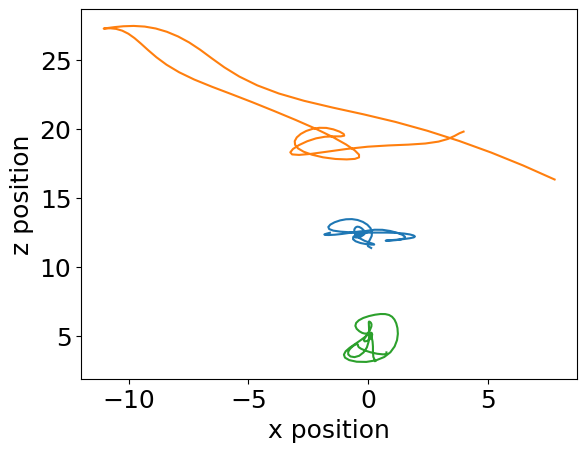

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

for traj in traj_list:
    ax.plot(traj.x, traj.z)

ax.set_xlabel('x position')
ax.set_ylabel('z position')

# Exercises

1. Generate a lot of unique trajectories. This takes a while. Running `generate_training_data.py` will generate the 3,000 trajectories that are saved in `../Data`
2. Analyze the distribution of your data -- does it capture a sufficiently broad range of movement motifs? Does it include a lot of high observability trajectories?